**рекуррентная нейронная сеть Элмана**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

----

In [ ]:
# простая языковая модель на маленьком тексте
# предсказания следующего слова/буквы в слове

## генерируем данные

In [2]:
# rng.randint?

In [3]:
# будем предсказывать следующий элемент последовательности
n_samples = 3000 #  количество примеров
seq_len = 4 #  длинна последовательности

S = rng.randint(low=0,high=10, size=(n_samples,seq_len))

Sbin = np.eye(S.max()+1)[S] # [ номер примера, номер элемента последовательности, код элемента ]

X = Sbin[:,:-1,:] # входная последовательность
y = Sbin[:,-1,:] # последний элемент для предсказания

X.shape,y.shape

((3000, 3, 10), (3000, 10))

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

del X
del y

In [5]:
X_train.shape,y_train.shape

((2700, 3, 10), (2700, 10))

## строим модель

рекуррентная сеть Элмана 

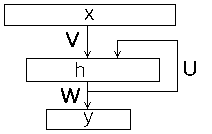

In [6]:
def state(x,w,b=0.): # состояние нейронов
    return x.dot(w) + b

In [7]:
def bp_sigmoid(u): # функция активации
    return np.tanh(u)

def d_bp_sigmoid(u): # производная активации
    return 1./(np.cosh(u)**2)

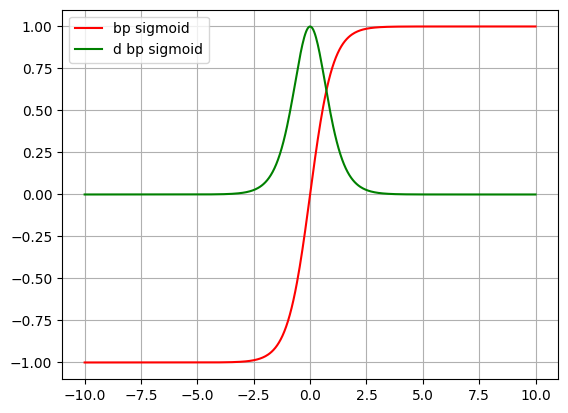

In [8]:
u=np.linspace(-10,10,500)
plt.plot( u,bp_sigmoid(u),'-r', label='bp sigmoid' )
plt.plot( u,d_bp_sigmoid(u),'-g', label='d bp sigmoid' )
plt.grid()
plt.legend()

In [9]:
def layer_rc(x,w,w1,b): # выход рекурентного слоя
    seq_len = x.shape[1] # длина последовательности 
    n_samples = x.shape[0] # количество примеров
    o = np.zeros( shape=(n_samples,w1.shape[0]) ) # начальные значения памяти сети
    for i in range(seq_len): # прогоняем через сеть последовательность примеров
        o = bp_sigmoid( state(x[:,i,:],w) + state(o,w1) + b )
    return o

def layer_ff(x,w,b): # выход слоя прямого распространения
    return bp_sigmoid( state( x,w,b) )

In [10]:
def score(x,weight): # выход сети по схеме many-to-one
    w,w1,b = weight[0] # веса первого обрабатывающего слоя и веса обратной связи
    o = layer_rc(x,w,w1,b)
    
    w,b = weight[1]
    o = layer_ff(o,w,b)
        
    return o

In [11]:
# инициализация параметров сети
def weight_init(input_size,hidden_size,output_size):
    return [ 
        [ 
            rng.normal( size=(input_size,hidden_size),scale=.1), 
            rng.normal( size=(hidden_size,hidden_size),scale=.1), 
            rng.normal( size=(1,hidden_size),scale=.1), 
        ],
        [ 
            rng.normal( size=(hidden_size,output_size),scale=.1), 
            rng.normal( size=(1,output_size),scale=.1), 
        ],
    ]

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [12]:
def msqe(y,o): # функция потери - средняя квадратичная ошибка
    return np.square(o-y).sum()/(len(y)*y.shape[1])

loss = msqe

модификация back propagation для рекуррентных сетей - BPTT

In [13]:
def forward(x,weight): # прямой проход
    layers_state = []
    layers_output = []
    
    seq_len = x.shape[1] # длина последовательности 
    n_samples = x.shape[0] # количество примеров

    w,w1,b = weight[0]
    o = np.zeros( shape=(n_samples,w1.shape[0]) ) # начальные значения памяти сети
     
    for i in range(seq_len): # прогоняем через сеть последовательность примеров
        s = state(x[:,i,:],w) + state(o,w1) + b # состояние скрытого слоя
        layers_state.append(s)
        o = bp_sigmoid(s) # выход скрытого слоя
        layers_output.append(o)
        
    w,b = weight[1]
    s = state(o,w,b) 
    layers_state.append(s)
    o = bp_sigmoid(s)
    layers_output.append(o)    
    
    return (
        layers_state, # состояние слоёв сети для каждого элемента последовательности
        layers_output # выходы слоёв сети для каждого элемента последовательности
    )

In [14]:
def backward(d_output,layers_state,weight): # обратный проход
    delta = [ d_output ]
    
    # ошибка скрытого слоя на последнем элементе входной последовательности
    w,_ = weight[1]
    s = layers_state[-2]
    d = d_output.dot(w.T) * d_bp_sigmoid(s)
    delta.append(d)
    
    w,w1,_ = weight[0]
    for s in layers_state[:-2][::-1]: # выкинуть последние два, список в обратном порядке
        d = d_bp_sigmoid(s)*d.dot(w1.T)
        delta.append(d)

    return delta[::-1] # значение ошибки для всех нейронов скрытых слоёв

In [15]:
def weight_norm(weight): # нормируем значения градиента
    w_max = max([ np.abs(w).max() for l in weight for w in l ])
    if w_max>0.: return [ [ w/w_max for w in l ] for l in weight ]
    return weight

In [16]:
def msqe_partial(x,weight,y): # градиент функции потери
    seq_len = x.shape[1] # длинна последовательностей

    layers_state, layers_output = forward(x,weight) # состояния и выходы всех нейронов сети
    d_output = (layers_output[-1]-y)* d_bp_sigmoid(layers_state[-1]) # ошибка выходного слоя
    delta = backward(d_output,layers_state,weight) # значение ошибки для всех нейронов скрытых слоёв

    dw0,dw0r,db0 = 0.,0.,0.
    for i in range(0,seq_len-1):
        dw0 += x[:,i,:].T.dot( delta[i] )
        dw0r += layers_output[i].T.dot( delta[i] )
        db0 += delta[i].sum(axis=0,keepdims=True) 
    
    dw1 = layers_state[-2].T.dot(delta[-1])
    db1 = delta[-1].sum(axis=0,keepdims=True)
    
    return weight_norm([[dw0,dw0r,db0],[dw1,db1]]) # нормируем значения градиента

gradient = msqe_partial

In [17]:
# корректируем параметры
def weight_adjust(weight,d_weight,lr):
    return [ 
        [ w-lr*dw for w,dw in zip(*l) ]  
        for l in zip(weight,d_weight) 
    ]

In [18]:
def fit_epoch(x,weight,y,lr): # шаг обучения модели
    d_weight = gradient(x,weight,y) # градиент функции потери, изменение весов
    return weight_adjust(weight,d_weight,lr) # корректируем параметры

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
weight = weight_init(input_size=X_train.shape[-1],hidden_size=25,output_size=y_train.shape[-1])

In [21]:
%%time

# метод градиентного спуска

lr = 5e-2 # скорость обучени
n_samples = len(y_train) # количество примеров
n_epoch = 2000 # максимальное число циклов обучения
acc_min = .91 # порог минимально допустимой погрешности модели

target = np.argmax(y_train, axis=1 )

# начальное значение ф-ции потери
loss_history = [ loss(y_train,score(X_train,weight)) ]
acc_history = [ accuracy_score( target, np.argmax(score(X_train,weight),axis=1) ) ]
                               

for i in range(n_epoch): # цикл обучения
    weight = fit_epoch(X_train,weight,y_train,lr) # корректируем веса модели
    loss_history.append( loss(y_train,score(X_train,weight)) ) # считаем значение ф-ции потери
    acc_history.append( accuracy_score( target, np.argmax(score(X_train,weight),axis=1) ) )
    
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
        break

CPU times: user 1min 2s, sys: 1min 12s, total: 2min 15s
Wall time: 37.4 s


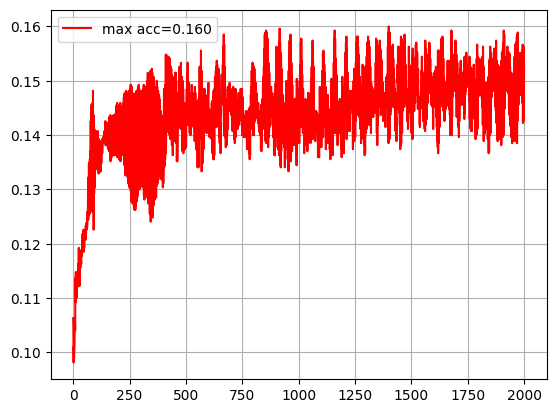

In [22]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)),color='r')
plt.grid()
plt.legend()

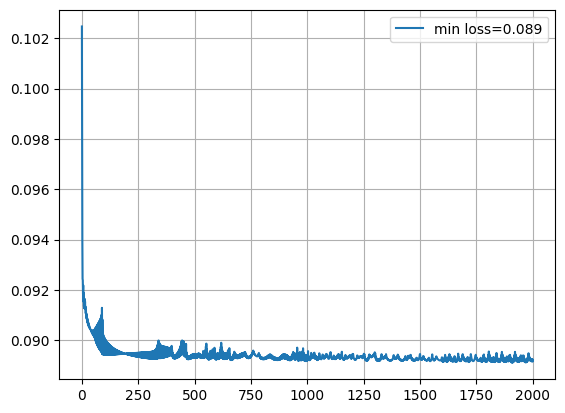

In [23]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [24]:
import pandas as pd
from sklearn.metrics import classification_report

In [25]:
p = np.argmax(score(X_train,weight), axis=1 )
target = np.argmax(y_train, axis=1 )
pd.DataFrame({'sequence': list(np.argmax(X_train,axis=-1)),'target':target,'predicted':p})

,sequence,target,predicted
0,"[1, 1, 3]",1,6
1,"[1, 0, 7]",4,4
2,"[9, 2, 0]",2,4
3,"[8, 8, 7]",7,4
4,"[6, 6, 1]",7,3
...,...,...,...
2695,"[0, 7, 2]",5,2
2696,"[1, 3, 8]",6,8
2697,"[8, 1, 3]",8,1
2698,"[5, 4, 3]",1,9


In [26]:
accuracy_score(target,p)

0.15296296296296297

In [27]:
print(classification_report(target,p))

              precision    recall  f1-score   support

           0       0.20      0.14      0.16       268
           1       0.13      0.16      0.14       268
           2       0.14      0.27      0.19       289
           3       0.16      0.13      0.14       256
           4       0.16      0.24      0.19       267
           5       0.11      0.01      0.01       269
           6       0.15      0.27      0.19       293
           7       0.14      0.08      0.10       255
           8       0.15      0.05      0.07       266
           9       0.16      0.17      0.17       269

    accuracy                           0.15      2700
   macro avg       0.15      0.15      0.14      2700
weighted avg       0.15      0.15      0.14      2700



----

In [28]:
# на тесте - не работает, переобучение 

In [29]:
p = np.argmax(score(X_test,weight), axis=-1 )
target = np.argmax(y_test, axis=-1 )
pd.DataFrame({'sequence': list(np.argmax(X_test,axis=-1)),'target':target,'predicted':p})

,sequence,target,predicted
0,"[0, 2, 3]",0,1
1,"[1, 6, 5]",4,8
2,"[6, 8, 7]",9,1
3,"[8, 4, 9]",2,9
4,"[7, 0, 1]",7,4
...,...,...,...
295,"[5, 6, 3]",6,4
296,"[7, 7, 4]",4,3
297,"[0, 9, 4]",3,6
298,"[3, 8, 1]",4,6


In [30]:
accuracy_score(target,p)

0.056666666666666664

In [31]:
# print(classification_report(target,p))